### Get macroeconomic variables for selected countries

In [1]:
import wbdata
import pandas as pd
from datetime import datetime
import eurostat
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
# --- Configuration ---
wb_indicators = {
    'SL.UEM.TOTL.ZS': 'Unemployment Rate (%)',
    'NY.GDP.MKTP.KD.ZG': 'GDP Growth (%)',
    'FS.AST.PRVT.GD.ZS': 'Household Debt-to-GDP (%)', # Check this indicator if needed
    'SL.EMP.TOTL.SP.ZS': 'Employment Rate (%)',
    'NE.CON.PRVT.ZS': 'Household Consumption (% of GDP)',
    'FP.CPI.TOTL.ZG': 'Inflation Rate (%)', # Inflation data needed for real HPI calc
}

# Extend date range slightly back if needed for 3-year rolling window start
start_year_data = 2000
end_year_data = 2023 # Use data up to this year
data_date = (datetime(start_year_data, 1, 1), datetime(end_year_data, 1, 1))

# ISO3 codes for World Bank
european_countries_wb_iso3 = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FIN','FRA',
                              'DEU','GRC','HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD',
                              'POL','PRT','ROU','SVK','SVN','ESP','SWE']

# Eurostat codes
european_countries_eurostat_codes = [
    'BE', 'BG', 'CZ', 'DK', 'DE', 'EE', 'IE', 'EL', 'ES', # EL is Greece
    'FR', 'HR', 'IT', 'CY', 'LV', 'LT', 'LU', 'HU', 'MT', 'NL', 'AT', 'PL',
    'PT', 'RO', 'SI', 'SK', 'FI', 'SE'
]

# Mapping from Eurostat codes to World Bank Full Country Names
eurostat_to_wb_map = {
    'AT': 'Austria', 'BE': 'Belgium', 'BG': 'Bulgaria', 'HR': 'Croatia', 'CY': 'Cyprus',
    'CZ': 'Czech Republic', 'DK': 'Denmark', 'EE': 'Estonia', 'FI': 'Finland', 'FR': 'France',
    'DE': 'Germany', 'EL': 'Greece', 'HU': 'Hungary', 'IE': 'Ireland', 'IT': 'Italy',
    'LV': 'Latvia', 'LT': 'Lithuania', 'LU': 'Luxembourg', 'MT': 'Malta', 'NL': 'Netherlands',
    'PL': 'Poland', 'PT': 'Portugal', 'RO': 'Romania', 'SK': 'Slovak Republic',
    'SI': 'Slovenia', 'ES': 'Spain', 'SE': 'Sweden'
}

# --- Retrieve World Bank Data ---
print("Retrieving World Bank data...")
wb_df = wbdata.get_dataframe(wb_indicators, country=european_countries_wb_iso3, date=data_date)
wb_df = wb_df.reset_index()
wb_df.rename(columns={'country':'Country', 'date':'Year'}, inplace=True)
wb_country_names = wb_df['Country'].unique().tolist()
wb_df = wb_df.melt(id_vars=['Country', 'Year'], var_name='Indicator', value_name='Value')
wb_df['Year'] = wb_df['Year'].astype(int) # Ensure Year is integer early

# --- Retrieve Eurostat Data ---
print("Retrieving Eurostat data...")
dataset_code = 'prc_hpi_a'
eurostat_df = pd.DataFrame() # Initialize empty DF
try:
    hpi_data = eurostat.get_data_df(dataset_code, flags=False)
    if hpi_data is not None and not hpi_data.empty:
        required_cols = ['purchase', 'unit', 'geo\\TIME_PERIOD']
        if all(col in hpi_data.columns for col in required_cols):
            idx_1 = hpi_data['purchase'] == 'TOTAL'
            idx_2 = hpi_data['unit'] == 'RCH_A_AVG' # Nominal Annual % Change
            eurostat_df_filtered = hpi_data[idx_1 & idx_2].copy()

            if not eurostat_df_filtered.empty:
                eurostat_df_filtered.rename(columns={'geo\\TIME_PERIOD': 'geo_code'}, inplace=True)
                eurostat_df_filtered = eurostat_df_filtered[eurostat_df_filtered['geo_code'].isin(eurostat_to_wb_map.keys())]
                eurostat_df_filtered['Country'] = eurostat_df_filtered['geo_code'].map(eurostat_to_wb_map)
                eurostat_df_filtered = eurostat_df_filtered[eurostat_df_filtered['Country'].isin(wb_country_names)]

                id_vars_melt = ['Country', 'freq', 'purchase', 'unit', 'geo_code']
                value_vars_melt = [col for col in eurostat_df_filtered.columns if col not in id_vars_melt]
                eurostat_df = eurostat_df_filtered.melt(
                    id_vars=id_vars_melt, value_vars=value_vars_melt,
                    var_name='Year', value_name='Value'
                )
                eurostat_df = eurostat_df.drop(columns=['freq', 'purchase', 'unit', 'geo_code'])
                eurostat_df['Indicator'] = 'House Price Index Annual Change (%)'
                eurostat_df = eurostat_df[pd.to_numeric(eurostat_df['Year'], errors='coerce').notna()]
                eurostat_df['Year'] = eurostat_df['Year'].astype(int)
                eurostat_df['Value'] = pd.to_numeric(eurostat_df['Value'], errors='coerce')
                eurostat_df.dropna(subset=['Value'], inplace=True)
        else:
             print(f"Error: Raw Eurostat data missing required columns. Found: {hpi_data.columns}")
    else:
        print(f"Warning: Could not retrieve Eurostat data for '{dataset_code}' or it was empty.")

except Exception as e:
    print(f"An error occurred during Eurostat processing: {e}")

# --- Combine Data ---
if not eurostat_df.empty:
    combined_df = pd.concat([wb_df, eurostat_df], ignore_index=True)
else:
     print("Warning: Eurostat HPI data is missing, proceeding with only World Bank data.")
     combined_df = wb_df

combined_df.sort_values(['Country', 'Year', 'Indicator'], inplace=True)
print("Initial data combination and sorting done.")

Retrieving World Bank data...
Retrieving Eurostat data...
Initial data combination and sorting done.


In [3]:
# Review the results
combined_df.pivot_table(index='Country', columns='Indicator', values='Year', aggfunc='count')

Indicator,Employment Rate (%),GDP Growth (%),House Price Index Annual Change (%),Household Consumption (% of GDP),Household Debt-to-GDP (%),Inflation Rate (%),Unemployment Rate (%)
Country,,,,,,,
Austria,24.0,24.0,13.0,24.0,24.0,24.0,24.0
Belgium,24.0,24.0,18.0,24.0,24.0,24.0,24.0
Bulgaria,24.0,24.0,18.0,24.0,24.0,24.0,24.0
Croatia,24.0,24.0,15.0,24.0,24.0,24.0,24.0
Cyprus,24.0,24.0,18.0,24.0,24.0,24.0,24.0
Czechia,24.0,24.0,NaN,24.0,24.0,24.0,24.0
Denmark,24.0,24.0,18.0,24.0,24.0,24.0,24.0
Estonia,24.0,24.0,18.0,24.0,24.0,24.0,24.0
Finland,24.0,24.0,18.0,24.0,24.0,24.0,24.0


In [4]:
# Inspect the HPI index
idx = combined_df['Indicator'] == 'House Price Index Annual Change (%)'
combined_df[idx].pivot_table(index='Country', columns='Year', values='Value', aggfunc='mean')

Year,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Country,,,,,,,,,,,,,,,,,,
Austria,NaN,NaN,NaN,NaN,NaN,5.4,6.6,5.0,3.8,5.6,6.7,5.1,6.0,6.0,7.6,11.4,11.6,-2.9
Belgium,9.8,7.8,4.3,-0.4,2.3,3.6,2.4,1.5,-0.3,1.8,2.3,3.5,3.0,3.7,4.3,6.7,5.5,2.3
Bulgaria,14.7,28.9,25.0,-20.4,-10.2,-5.5,-1.9,-2.2,1.4,2.8,7.0,8.7,6.6,6.0,4.6,8.7,13.8,9.9
Croatia,NaN,NaN,NaN,-5.0,-6.3,0.2,-1.6,-3.9,-1.6,-2.9,0.9,3.8,6.1,9.0,7.7,7.3,14.8,11.9
Cyprus,11.9,11.7,5.6,-6.6,-5.7,-1.6,-3.1,-4.1,-1.8,-1.5,0.3,2.2,1.8,3.7,-0.2,-3.4,2.7,2.9
Denmark,24.1,2.7,-5.2,-12.0,2.8,-1.7,-2.7,3.9,3.8,7.0,4.6,5.0,4.4,2.2,4.3,11.5,4.7,-3.8
Estonia,49.5,20.8,-9.6,-37.2,5.7,8.5,7.3,10.7,13.7,6.9,4.7,5.5,5.9,7.0,6.0,15.0,22.2,5.9
Finland,7.0,5.9,0.8,1.4,6.3,3.2,2.4,1.2,-0.4,0.0,1.3,1.1,0.9,0.4,1.8,4.6,1.2,-5.7
France,11.6,6.4,0.9,-6.1,4.6,5.7,-0.5,-1.9,-1.5,-1.3,1.0,3.2,2.9,3.3,5.2,6.3,6.3,-0.4


In [5]:
# Pivot to get HPI and Inflation side-by-side
pivot_df = combined_df.pivot_table(
    index=['Country', 'Year'],
    columns='Indicator',
    values='Value'
)

pivot_df['Real HPI Change (%)'] = pivot_df['House Price Index Annual Change (%)'] - pivot_df['Inflation Rate (%)']
pivot_df['Sum Real HPI Change (3yr)'] = pivot_df.groupby('Country')['Real HPI Change (%)'].transform(lambda x: x.rolling(window=3, min_periods=1).sum())
pivot_df = pivot_df.reset_index()

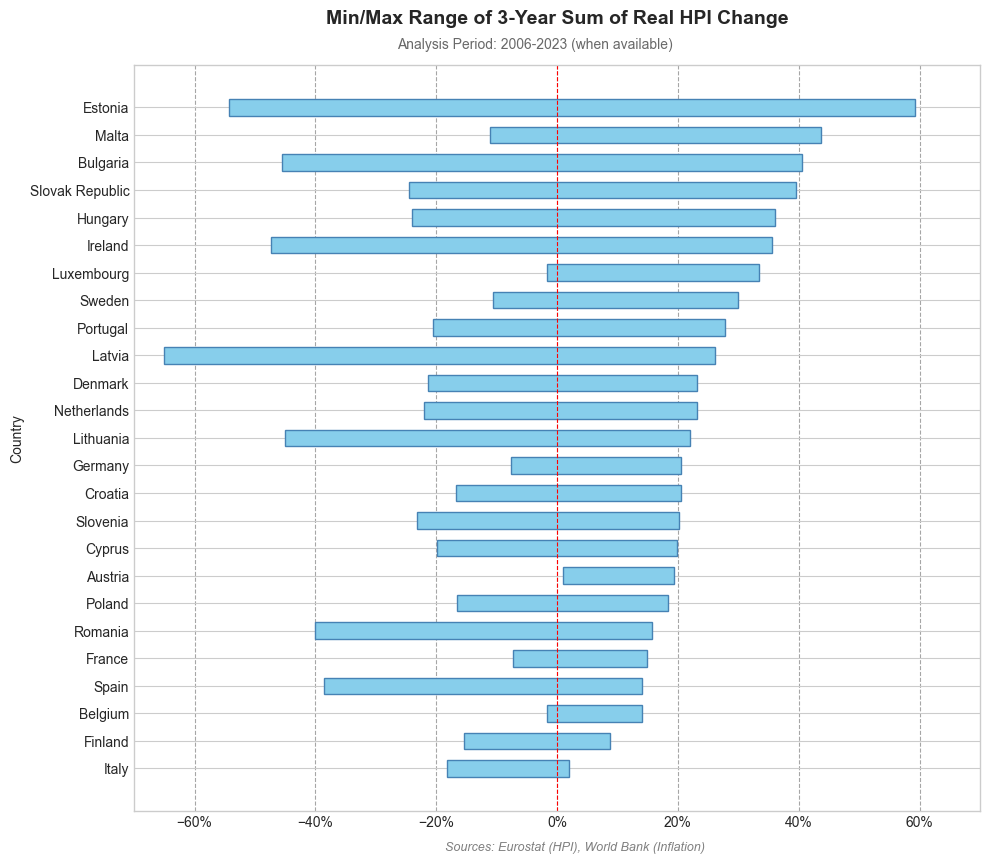

In [6]:
# Create df for plotting
df_summary = pivot_df.groupby('Country').agg({'Sum Real HPI Change (3yr)': ['min', 'max']}) / 100
df_summary.columns = ['min', 'max']
df_summary.dropna()

# Convert min/max columns to numeric, coercing errors for potential empty strings
df_summary['min'] = pd.to_numeric(df_summary['min'], errors='coerce')
df_summary['max'] = pd.to_numeric(df_summary['max'], errors='coerce')

# --- Data Preparation for Plotting ---
df_plot = df_summary.dropna(subset=['min', 'max'])
df_plot = df_plot.sort_values('max', ascending=True)

# --- Create the Graph ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, len(df_plot) * 0.3 + 1))

# --- Plotting: Horizontal Bars ---
bar_width = df_plot['max'] - df_plot['min']
bars = ax.barh(df_plot.index, 
               bar_width, 
               left=df_plot['min'], 
               color='skyblue', 
               edgecolor='steelblue', 
               height=0.6)

# Add a line at zero for reference and x axis range
ax.axvline(0, color='red', linestyle='--', linewidth=0.8, zorder=1)
ax.set_xlim(-0.7, 0.7)

# Customize the plot
ax.set_ylabel('Country')
ax.set_title('Min / Max Range of 3-Year Sum of Real HPI Change', fontsize=14, fontweight='bold', pad=30) 
fig.text(0.54, 0.95, "Analysis Period: 2006-2023 (conditional on availability)", 
         ha='center', 
         va='top', 
         fontsize=10, 
         color='dimgray')

ax.tick_params(axis='y', length=0)
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

# Add grid lines for readability on the x-axis
ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.7)
ax.set_axisbelow(True)

source_text = "Sources: Eurostat (HPI), World Bank (Inflation)"
fig.text(0.45, -0.01, 
         source_text, 
         ha='left', 
         va='bottom', 
         fontsize=9, 
         color='gray', 
         fontstyle='italic')

plt.tight_layout()
plt.show()